In [2]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

# Display OFF Files

In [3]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [4]:
path = '/kaggle/input/modelnet10-princeton-3d-object-dataset/ModelNet10/night_stand/train/night_stand_0001.off'
with open(path, 'r') as f:
  verts, faces = read_off(f)

i,j,k = np.array(faces).T
x,y,z = np.array(verts).T
len(x)

64754

In [5]:
import plotly.io as pio

# Set Plotly renderer for Kaggle
pio.renderers.default = 'iframe'

def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i,j=j,k=k)]).show()

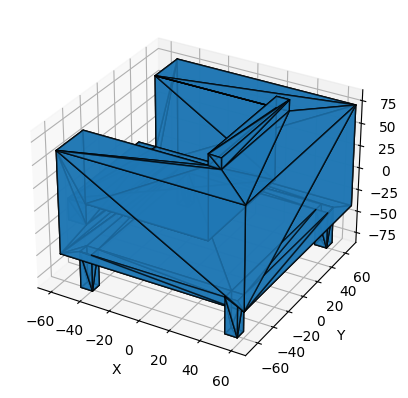

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Function to load OFF file
def load_off(filename):
    with open(filename, 'r') as file:
        # Read the first line (OFF)
        if file.readline().strip() != 'OFF':
            raise ValueError("Not a valid OFF file")

        # Read the number of vertices and faces
        n_verts, n_faces, _ = map(int, file.readline().strip().split())
        
        # Read vertices
        vertices = []
        for _ in range(n_verts):
            vertices.append(list(map(float, file.readline().strip().split())))
        vertices = np.array(vertices)

        # Read faces
        faces = []
        for _ in range(n_faces):
            face_data = list(map(int, file.readline().strip().split()))
            face_indices = face_data[1:]  # skip the first number (number of vertices per face)
            faces.append(face_indices)

    return vertices, faces

# Load OFF file
vertices, faces = load_off('/kaggle/input/modelnet10-princeton-3d-object-dataset/ModelNet10/sofa/test/sofa_0681.off')

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a 3D polygon collection for the faces
mesh = Poly3DCollection(vertices[faces], alpha=0.6, edgecolor='k')
ax.add_collection3d(mesh)

# Set plot limits
ax.set_xlim(vertices[:, 0].min(), vertices[:, 0].max())
ax.set_ylim(vertices[:, 1].min(), vertices[:, 1].max())
ax.set_zlim(vertices[:, 2].min(), vertices[:, 2].max())

# Labels and display
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


In [5]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

pcshow(x,y,z)

In [6]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points


pointcloud = PointSampler(1024)((verts, faces))  #You can also specify more points, for example 3000
pcshow(*pointcloud.T)

# Transforms

In [7]:
import numpy as np
import torch
import random

class Normalize(object):
    def __call__(self, point_cloud):
        """
        Normalizes the point cloud to zero mean and unit variance.
        
        Args:
            point_cloud (np.ndarray): Input point cloud of shape (N, 3).
        
        Returns:
            np.ndarray: Normalized point cloud.
        """
        centroid = point_cloud.mean(axis=0)
        point_cloud = point_cloud - centroid
        scale = np.max(np.linalg.norm(point_cloud, axis=1))
        return point_cloud / scale

class RandRotation_z(object):
    def __call__(self, point_cloud):
        """
        Rotates the point cloud around the Z-axis by a random angle.
        
        Args:
            point_cloud (np.ndarray): Input point cloud of shape (N, 3).
        
        Returns:
            np.ndarray: Rotated point cloud.
        """
        rotation_angle = random.uniform(0, 2 * np.pi)
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, -sinval, 0],
                                    [sinval, cosval, 0],
                                    [0, 0, 1]])
        return point_cloud @ rotation_matrix.T  # Apply rotation

class RandomNoise(object):
    def __init__(self, sigma=0.01):
        """
        Adds Gaussian noise to the point cloud.
        
        Args:
            sigma (float): Standard deviation of the Gaussian noise.
        """
        self.sigma = sigma

    def __call__(self, point_cloud):
        """
        Adds Gaussian noise to the point cloud.
        
        Args:
            point_cloud (np.ndarray): Input point cloud of shape (N, 3).
        
        Returns:
            np.ndarray: Noisy point cloud.
        """
        noise = np.random.normal(0, self.sigma, point_cloud.shape)
        return point_cloud + noise

class JitterPointCloud(object):
    def __init__(self, sigma=0.01, clip=0.05):
        """
        Initializes the JitterPointCloud class.
        
        Args:
            sigma (float): Standard deviation of the Gaussian noise.
            clip (float): Maximum absolute value of jitter per axis.
        """
        self.sigma = sigma
        self.clip = clip

    def __call__(self, point_cloud):
        """
        Adds jitter (small random noise) to each point in the point cloud.
        
        Args:
            point_cloud (np.ndarray): Input point cloud of shape (N, 3).
        
        Returns:
            np.ndarray: Jittered point cloud.
        """
        jitter = np.clip(self.sigma * np.random.randn(*point_cloud.shape), -self.clip, self.clip)
        return point_cloud + jitter

class TranslatePointCloud(object):
    def __init__(self, translate_range=0.1):
        """
        Initializes the TranslatePointCloud class.
        
        Args:
            translate_range (float): Maximum translation distance for each axis.
        """
        self.translate_range = translate_range

    def __call__(self, point_cloud):
        """
        Translates the point cloud by a random offset.
        
        Args:
            point_cloud (np.ndarray): Input point cloud of shape (N, 3).
        
        Returns:
            np.ndarray: Translated point cloud.
        """
        translation = (np.random.rand(3) - 0.5) * 2 * self.translate_range
        return point_cloud + translation

class ToTensor(object):
    def __call__(self, point_cloud):
        """
        Converts the point cloud to a torch.Tensor.
        
        Args:
            point_cloud (np.ndarray): Input point cloud of shape (N, 3).
        
        Returns:
            torch.Tensor: Point cloud as a torch.Tensor.
        """
        return torch.tensor(point_cloud, dtype=torch.float32)


In [9]:
rot_pointcloud = RandRotation_z()(pointcloud)
noisy_rot_pointcloud = RandomNoise()(pointcloud)
jitter_pointcloud = JitterPointCloud()(pointcloud)

In [10]:
pcshow(*pointcloud.T)

In [8]:
from torchvision import transforms

# Compose the transformations
train_transforms = transforms.Compose([
    PointSampler(1024),
    Normalize(),
    RandRotation_z(),
    RandomNoise(sigma=0.01),
    JitterPointCloud(sigma=0.01, clip=0.05),
    TranslatePointCloud(translate_range=0.1),
    ToTensor()
])


test_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    ToTensor()
                  ])


augmented_point_cloud = train_transforms((verts, faces))

# Output will be a torch.Tensor
print(augmented_point_cloud.shape)  # Should print torch.Size([1024, 3])
print(type(augmented_point_cloud))  # Should print <class 'torch.Tensor'>


torch.Size([1024, 3])
<class 'torch.Tensor'>


# Create Dataset

In [50]:
path = '/kaggle/input/modelnet10-princeton-3d-object-dataset/ModelNet10'
classes = sorted(os.listdir(path))
num_sample_cls={}
for c in classes:
    num_sample_cls[c] = {'train': len(glob(os.path.join(path, c, 'train/*'))),
                        'test': len(glob(os.path.join(path, c, 'test/*')))}
num_sample_cls

{'bathtub': {'train': 106, 'test': 50},
 'bed': {'train': 515, 'test': 100},
 'chair': {'train': 889, 'test': 100},
 'desk': {'train': 200, 'test': 86},
 'dresser': {'train': 200, 'test': 86},
 'monitor': {'train': 465, 'test': 100},
 'night_stand': {'train': 200, 'test': 86},
 'sofa': {'train': 680, 'test': 100},
 'table': {'train': 392, 'test': 100},
 'toilet': {'train': 344, 'test': 100}}

In [39]:
from glob import glob
import os

class ModelNetDataset(Dataset):
    def __init__(self, root, mode='train', transform=None):
        self.root = root
        self.mode = mode
        self.transforms = transform
        
        self.labels={}
        for i, item in enumerate(sorted(os.listdir(self.root))):
             self.labels[item]=i

        self.files=[]
        for lbl in self.labels.keys():
            off_files = glob(os.path.join(self.root, lbl, self.mode +'/*'))
            for file_path in off_files:
                sample={}
                sample['file_path'] = file_path
                sample['label'] = lbl
                self.files.append(sample)
                
    def __len__(self):
        return len(self.files)

    
    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms is not None:
            pointcloud = self.transforms((verts, faces))
        return pointcloud
        

    def __getitem__(self, idx):
        file_path = self.files[idx]['file_path']
        label = self.files[idx]['label']
        
        with open(file_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                # 'label': {label:self.labels[label]}}
                'label': self.labels[label]}
        # return {file_path:label}

In [40]:
path = '/kaggle/input/modelnet10-princeton-3d-object-dataset/ModelNet10'
train_ds = ModelNetDataset(path, mode='train', transform=train_transforms)
test_ds = ModelNetDataset(path, mode='test',transform=test_transforms)

In [41]:
data_train = train_ds[0]
data_train

{'pointcloud': tensor([[-0.5591, -0.2925,  0.0385],
         [ 0.1382, -0.3975,  0.3129],
         [-0.7433,  0.4000,  0.0279],
         ...,
         [ 0.4700,  0.0099,  0.1596],
         [ 0.3199, -0.3897,  0.0533],
         [ 0.2085, -0.5685,  0.2920]]),
 'label': 0}

In [24]:
data_test = test_ds[200]
data_test

{'pointcloud': tensor([[ 0.3015, -0.2448, -0.8920],
         [ 0.0011,  0.0906,  0.2119],
         [ 0.1719,  0.1190,  0.1694],
         ...,
         [ 0.3015, -0.1387, -0.7482],
         [ 0.1230, -0.1097,  0.1861],
         [-0.3071, -0.2421, -0.6767]]),
 'label': {'chair': 2}}

In [18]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(test_ds))
print('Number of classes: ', len(train_ds.labels))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])


In [21]:
pcshow(*data_train['pointcloud'].T)

In [25]:
pcshow(*data_test['pointcloud'].T)

In [42]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=32)

In [52]:
batch = next(iter(train_loader))
batch

{'pointcloud': tensor([[[-0.0122,  0.4779, -0.4270],
          [-0.4144, -0.0649,  0.2420],
          [-0.3847, -0.0371, -0.0448],
          ...,
          [-0.3590, -0.1970,  0.7136],
          [-0.2229,  0.0329,  0.0506],
          [-0.0317,  0.1005,  0.0490]],
 
         [[ 0.5249, -0.1630,  0.0995],
          [ 0.6258,  0.2962,  0.3636],
          [ 0.2875,  0.4952, -0.4236],
          ...,
          [-0.4432,  0.0262,  0.3743],
          [ 0.1489, -0.3513,  0.3010],
          [-0.4178,  0.5203, -0.0779]],
 
         [[ 0.5178,  0.1462,  0.1491],
          [-0.3762, -0.0578, -0.0573],
          [-0.0647,  0.0995, -0.0755],
          ...,
          [-0.0123,  0.0990, -0.0755],
          [ 0.1293,  0.2151, -0.1070],
          [-0.0023, -0.2455,  0.0562]],
 
         ...,
 
         [[-0.6412, -0.3616,  0.1604],
          [ 0.3077,  0.3728,  0.3087],
          [ 0.2677,  0.3262,  0.0640],
          ...,
          [ 0.8779, -0.2016,  0.0810],
          [-0.7714, -0.4656, -0.0043],
    